In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from datetime import timedelta

In [2]:
def lerp(start, end, t):
	r = start[0] + (end[0] - start[0]) * t
	g = start[1] + (end[1] - start[1]) * t
	b = start[2] + (end[2] - start[2]) * t
	a = start[3] + (end[3] - start[3]) * t
	return (r / 255.0, g / 255.0, b / 255.0, a)

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [3]:
# Max 42k
hex_list = ['#85ff00', '#fff100', '#ffaa04', '#ff0000', '#dc00ff', '#6700d4']#, '#1200db', '#0a014a']
scales = [0, 10, 100, 1000, 10000, 100000]#, 1000000, 10000000]
colors = [(0x85, 0xff, 0x00, 1.0), (0xff, 0xf1, 0x00, 1.0), (0xff, 0xaa, 0x04, 1.0), (0xff, 0x00, 0x00, 1.0), (0xdc, 0x00, 0xff, 1.0), (0x67, 0x00, 0xd4, 1.0), (0x12, 0x00, 0xdb, 1.0)]#, (0x12, 0x00, 0xdb, 1.0), (0x0a, 0x01, 0x4a, 1.0), ]

In [4]:
df = pd.read_csv('exposed_by_vendor_num_of_vulns.csv')
vendor_names = list(set(df['vendor'].unique()) - set(["?"]))

dates = sorted(list(df.date.unique()))

done = 0
output = {}
first_appearance = {}
for vendor in vendor_names:
	c = []
	for d in range(len(dates)):
		if not vendor in list(df[(df.date == dates[d])]['vendor']) or df[(df.date == dates[d]) & (df['vendor'] == vendor)]['vulnerability_count'].iloc[0] == 0:
			c += [(0, 0, 0, 0)]
		else:
			first_appearance[vendor] = dates[d]
			v = df[(df.date == dates[d]) & (df['vendor'] == vendor)]['vulnerability_count'].iloc[0]
			idx = -1
			for s in range(len(scales) - 1):
				if scales[s] < v and v <= scales[s+1]:
					idx = s
			if idx == -1:
				c += [lerp(colors[-1], colors[-1], 0.5)]
			else:
				c += [lerp(colors[idx], colors[idx+1], (v - scales[idx])/(scales[idx + 1] - scales[idx]))]
	done += 1
	print(f'{str(done).zfill(len(str(len(vendor_names))))}/{len(vendor_names)}: {vendor}')
	output[vendor] = c


01/32: Tridium
02/32: Citrix
03/32: D-Link
04/32: Arris
05/32: Western Digital
06/32: Barracuda Networks
07/32: NETGEAR
08/32: Watchguard
09/32: Nokia
10/32: Honeywell
11/32: Huawei
12/32: VMware
13/32: Moxa
14/32: Siemens
15/32: F5
16/32: Netis
17/32: Broadcom
18/32: AVM
19/32: DrayTek
20/32: Axis Communications
21/32: Cisco
22/32: Schneider Electric
23/32: TP-Link
24/32: HP
25/32: iCatch
26/32: Synology
27/32: ASUS
28/32: Polycom
29/32: Ubiquiti
30/32: ZTE
31/32: Dell
32/32: Zyxel


In [5]:
from json import dumps
jsonified = dumps(output)
with open('./exposed-vendor-num-of-vulns.json', 'w') as f:
    f.write(jsonified)
    f.close()

In [6]:
# Sort infection names initial date (color tuple not 0 0 0 0 ) then alphabetical
appearance = {}
for vendor in vendor_names:
    for c in range(len(output[vendor])):
        if output[vendor][c][0] != 0 or output[vendor][c][1] != 0 or output[vendor][c][2] != 0 or output[vendor][c][3] != 0:
            appearance[vendor] = c
            break

appearance_inv = {i: [] for i in range(len(dates))}

for v in sorted(list(appearance.items()), key=lambda x: x[1]):
    appearance_inv[v[1]] += [v[0]]

for i in range(len(dates)):
    if len(appearance_inv[i]) == 0:
        del(appearance_inv[i])
    else:
        appearance_inv[i] = sorted(appearance_inv[i])

vendor_names_sorted = [x for xs in [v for k, v in appearance_inv.items()] for x in xs][::-1]

In [7]:
norm=LogNorm(vmin=1, vmax=99999)
cmappable = ScalarMappable(norm=norm, cmap=get_continuous_cmap(hex_list=hex_list))

In [8]:
dates = sorted(list(df.date.unique()))
m_dates = mdates.num2date(mdates.datestr2num(dates))
m_dates[-1]

datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc)

01/32: Polycom
02/32: iCatch
03/32: Citrix
04/32: F5
05/32: Barracuda Networks
06/32: Moxa
07/32: Honeywell
08/32: AVM
09/32: Tridium
10/32: Nokia
11/32: Axis Communications
12/32: Arris
13/32: Broadcom
14/32: Huawei
15/32: Dell
16/32: HP
17/32: Netis
18/32: Watchguard
19/32: Cisco
20/32: D-Link
21/32: ZTE
22/32: Siemens
23/32: Schneider Electric
24/32: Zyxel
25/32: Western Digital
26/32: VMware
27/32: Ubiquiti
28/32: TP-Link
29/32: Synology
30/32: NETGEAR
31/32: DrayTek
32/32: ASUS


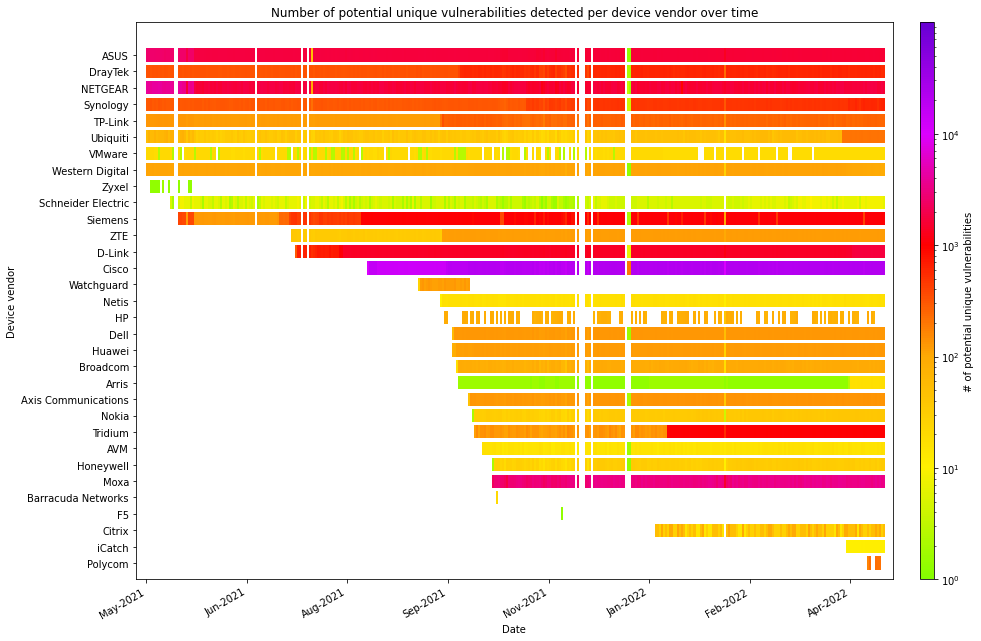

In [9]:

plt.rcParams["figure.figsize"] = (16.54, 11.38)

fig, ax = plt.subplots(figsize=(16.54, 11.38))
y = 0
done = 0

for vendor in vendor_names_sorted:
	for c in range(len(output[vendor])):
		ax.barh(y, 1, left= m_dates[c], height=0.8, align='center', color=output[vendor][c])
	y += 1
	done += 1
	print(f'{str(done).zfill(len(str(len(vendor_names))))}/{len(vendor_names)}: {vendor}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
ax.axis('tight')
ax.set_xlim([m_dates[0] - timedelta(days=5), m_dates[-1] + timedelta(days=5)])
ax.set_ylim([-1, len(vendor_names_sorted) + 1])
ax.set_yticks(np.arange(len(vendor_names_sorted)))
ax.set_yticklabels(vendor_names_sorted)


ax.set_xlabel('Date')
ax.set_ylabel('Device vendor')

fig.autofmt_xdate()

cb =fig.colorbar(cmappable, aspect=40, pad=0.03)
cb.ax.set_ylabel('# of potential unique vulnerabilities')

ax.set_title("Number of potential unique vulnerabilities detected per device vendor over time")

plt.savefig('../images/exposed-byvendor-num-vulns-better.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.2, dpi=300)
plt.show()